## NARX SST Región Niño 3.4

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

In [1]:
#https://www.tensorflow.org/tutorials/structured_data/time_series

In [2]:
from MONGO import CONEXION
from datetime import datetime
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

# Creando Coenxión con Mongo DB

In [3]:
# Creando la conexión con MongoDB
db = CONEXION.conexion()
db.list_collection_names()

['polygons', 'meteorological', 'SSTNino34']

# Descargando la Información SST NIÑO3.4

In [4]:
# Fecha actual
time = datetime.today().toordinal()

# Realizando consulta
sst_data = db.SSTNino34.find({"time":{"$lte":time}})

# Generando pandas dataframe
data_pandas = pd.DataFrame([file for file in sst_data])
data_pandas['periodo'] = data_pandas.time.apply(lambda x: datetime.fromordinal(x))
data_pandas['mes_year'] =  data_pandas['periodo'].dt.strftime('%B-%Y')
data_pandas.index = pd.to_datetime(data_pandas.periodo)
data_pandas.head(10)

,_id,year,month,nino34_mean,climatologica,anomalias,mes,time,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,
2022-06-01,62e6d1d870bebdf1983a27a9,2022,6,26.96,27.73,-0.77,junio,738307,738367,2022-06-01,June-2022
2022-05-01,62e6d1d870bebdf1983a27a8,2022,5,26.82,27.94,-1.12,mayo,738276,738367,2022-05-01,May-2022
2022-04-01,62e6d1d870bebdf1983a27a7,2022,4,26.71,27.83,-1.12,abril,738246,738367,2022-04-01,April-2022
2022-03-01,62e6d1d870bebdf1983a27a6,2022,3,26.32,27.29,-0.98,marzo,738215,738367,2022-03-01,March-2022
2022-02-01,62e6d1d870bebdf1983a27a5,2022,2,25.87,26.76,-0.90,febrero,738187,738367,2022-02-01,February-2022
2022-01-01,62e6d1d870bebdf1983a27a4,2022,1,25.60,26.55,-0.95,enero,738156,738367,2022-01-01,January-2022
2021-12-01,62e6d1d870bebdf1983a27a3,2021,12,25.54,26.60,-1.06,diciembre,738125,738367,2021-12-01,December-2021
2021-11-01,62e6d1d870bebdf1983a27a2,2021,11,25.76,26.70,-0.94,noviembre,738095,738367,2021-11-01,November-2021
2021-10-01,62e6d1d870bebdf1983a27a1,2021,10,25.78,26.72,-0.94,octubre,738064,738367,2021-10-01,October-2021


In [5]:
# Registros
print(data_pandas.shape)

(870, 11)


In [6]:
# Data disponible
print(data_pandas.index.min())
print(data_pandas.index.max())

1950-01-01 00:00:00
2022-06-01 00:00:00


### Modelos NARX

Data para el modelo NAARX

In [7]:
# Data modelo
data_model = data_pandas[['nino34_mean']].dropna().copy()
data_model['nino34_mean_exogena'] = data_model.nino34_mean

<AxesSubplot:xlabel='periodo'>

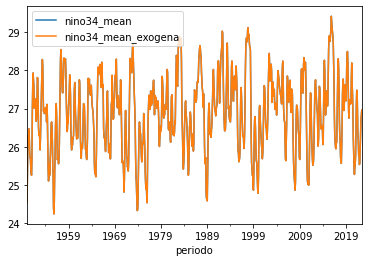

In [8]:
data_model.plot()

Definiendo variable de entrada y exógena

In [9]:
y_output = 'nino34_mean'
exogena = ['nino34_mean_exogena']

pd_model = data_model[ [y_output] + exogena].sort_index(ascending=True)
pd_model.head(10)

,nino34_mean,nino34_mean_exogena
periodo,,
1950-01-01,24.56,24.56
1950-02-01,25.07,25.07
1950-03-01,25.88,25.88
1950-04-01,26.29,26.29
1950-05-01,26.19,26.19
1950-06-01,26.47,26.47
1950-07-01,26.28,26.28
1950-08-01,25.88,25.88
1950-09-01,25.73,25.73


Normalización de los datos

In [10]:
t_exogena = ['t_' + x for x in exogena]
t_output = 't_' + y_output


data_mean = pd_model.mean()
data_std = pd_model.std()

pd_model[t_output] = (pd_model[y_output] - data_mean[data_mean.index==y_output][0])/data_std[data_std.index==y_output][0]

for x in exogena:
    pd_model['t_' + x] = (pd_model[x] - data_mean[data_mean.index==x][0])/data_std[data_std.index==x][0]

In [11]:
data_modelo = pd_model[[t_output]+t_exogena]
data_modelo.head(10)

,t_nino34_mean,t_nino34_mean_exogena
periodo,,
1950-01-01,-2.380617,-2.380617
1950-02-01,-1.859887,-1.859887
1950-03-01,-1.032845,-1.032845
1950-04-01,-0.614219,-0.614219
1950-05-01,-0.716323,-0.716323
1950-06-01,-0.430432,-0.430432
1950-07-01,-0.624430,-0.624430
1950-08-01,-1.032845,-1.032845
1950-09-01,-1.186001,-1.186001


Parámetros de del modelo NARX 

In [12]:
prediction_order = 12 # rango de prediccion
auto_order = 24 # componente autoregresiva
exog_order = 12 # componente exogena qm
exog_delay = 0 # componente exogena dm

In [13]:
def date_window(pd_model,auto_order,exog_order,exog_delay,exogena,output):
    """
    Funcion para estructurar los datos de entrada del modelo NARX
    """

    X = pd_model[exogena].to_numpy().astype(float)
    y = pd_model[[output]].to_numpy().astype(float)

    # Data para el mmodelo
    input_data = []
    output_data = []
    for t in range(max(auto_order, exog_order), len(y)):
        input_data.append(np.concatenate((y[(t - auto_order + 1):(t + 1)], X[(t - exog_delay - exog_order + 1):(t - exog_delay + 1)]), axis=0) )
        output_data.append(np.array(y[t]))

    # Input del modelo
    input_data = np.array(input_data)
    # Output del modelo
    output_data = np.array(output_data)

    return (input_data,output_data)

In [14]:
# Data Test
data_test = data_modelo[:-prediction_order]
input_data, output_data = date_window(pd_model=data_test,
                                        auto_order=auto_order,
                                        exog_order=exog_order,
                                        exog_delay=exog_delay,
                                        exogena=t_exogena,
                                        output=t_output)

print(input_data.shape)
print(output_data.shape)

(834, 36, 1)
(834, 1)


In [29]:
# Neuronas capa entrada
_ , ninp, _ = input_data.shape

# Capas de la red
input_ = keras.layers.Input(shape=(ninp,))
hidden1 = keras.layers.Dense(ninp, activation="selu",kernel_initializer="lecun_normal",)(input_)
hidden2 = keras.layers.Dense(ninp, activation="selu",kernel_initializer="lecun_normal")(hidden1)
hidden3 = keras.layers.Dense(ninp, activation="selu",kernel_initializer="lecun_normal")(hidden2)
output = keras.layers.Dense(1)(hidden3)

# Definiendo red 
model = keras.models.Model(inputs=[input_],outputs=[output])

# Definiendo optimizador y learning rate
optimizer = keras.optimizers.Nadam(learning_rate = 1e-3)

# Compilando el modelo a entrenar
model.compile(loss="mean_squared_error", optimizer=optimizer)

In [30]:
# Parametros de entrenamiento
epochs = 1000
batch_size = 32
validation_split = 0.30

path_checkpoint = "./model_checkpoint/narx_sst_nino34.h5"

patience = 10
min_delta = 0

# Entrenando la red
es_callback = keras.callbacks\
                    .EarlyStopping(monitor="val_loss",
                                   min_delta=min_delta,
                                   patience=patience,
                                   mode='min')

modelckpt_callback = keras.callbacks\
                            .ModelCheckpoint(
                                    monitor="val_loss",
                                    filepath=path_checkpoint,
                                    verbose=0,
                                    save_weights_only=True,
                                    save_best_only=True)

history = model.fit(
                x=input_data,
                y=output_data,
                epochs=epochs,
                verbose=0,
                validation_split=validation_split,
                callbacks=[es_callback, modelckpt_callback])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 36)]              0         
                                                                 
 dense_4 (Dense)             (None, 36)                1332      
                                                                 
 dense_5 (Dense)             (None, 36)                1332      
                                                                 
 dense_6 (Dense)             (None, 36)                1332      
                                                                 
 dense_7 (Dense)             (None, 1)                 37        
                                                                 
Total params: 4,033
Trainable params: 4,033
Non-trainable params: 0
_________________________________________________________________


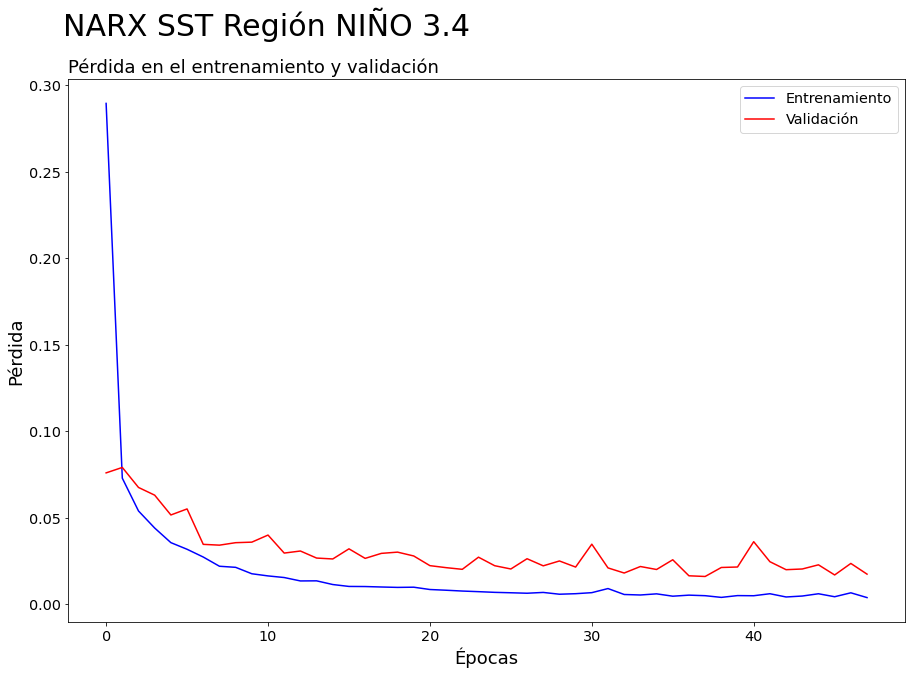

In [31]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

def visualizar_perdida(history, title):
    """
    Funcion para visualizar la funcion de perdida de la red NARX
    """
    params = {'legend.fontsize': 'x-large',
            #'figure.figsize': (15, 10),
            'axes.labelsize': 'x-large',
            'axes.titlesize':'x-large',
            'xtick.labelsize':'x-large',
            'ytick.labelsize':'x-large'}

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(figsize=(15,10))
    pylab.rcParams.update(params)
    plt.plot(epochs, loss, "b", label="Entrenamiento")
    plt.plot(epochs, val_loss, "r", label="Validación")
    
    plt.title('Pérdida en el entrenamiento y validación',loc='left',fontsize=18)
    plt.suptitle(title,ha='left',fontsize=30,x=0.12)
    plt.xlabel("Épocas",fontsize=18)
    plt.ylabel("Pérdida",fontsize=18)
    plt.legend()
    plt.show()

visualizar_perdida(history, "NARX SST Región NIÑO 3.4")

# Validación del modelo

Datos para validación

In [64]:
prediction_test = model.predict(input_data,
                                batch_size=batch_size,
                                verbose=0,
                                steps=None,
                                callbacks=None,
                                max_queue_size=10,
                                workers=1,
                                use_multiprocessing=False)

In [115]:
pd_test_2 = pd_model.copy().reset_index(drop=False)
pd_test_2['prediction'] = np.nan
pd_test_2['type'] = 'training'
pd_test_2.loc[ data_test.shape[0]: , 'type' ] = 'validation'

# Prediccion training
pd_test_2.loc[ range(max(auto_order, exog_order),(data_test.shape[0])), 'prediction' ] = (prediction_test*data_std[data_std.index==y_output][0])+ data_mean[data_mean.index==y_output][0]

pd_test_2.head()

,periodo,nino34_mean,nino34_mean_exogena,t_nino34_mean,t_nino34_mean_exogena,prediction,type
0,1950-01-01,24.56,24.56,-2.380617,-2.380617,NaN,training
1,1950-02-01,25.07,25.07,-1.859887,-1.859887,NaN,training
2,1950-03-01,25.88,25.88,-1.032845,-1.032845,NaN,training
3,1950-04-01,26.29,26.29,-0.614219,-0.614219,NaN,training
4,1950-05-01,26.19,26.19,-0.716323,-0.716323,NaN,training


<AxesSubplot:>

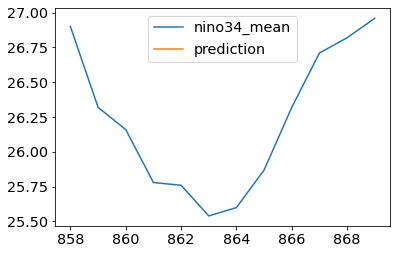

In [114]:
pd_test_2[pd_test_2.type=='validation'][['nino34_mean','prediction']].plot()

In [118]:
input_data_validate, _ = date_window(pd_model=data_modelo.copy(),
                                    auto_order=auto_order,
                                    exog_order=exog_order,
                                    exog_delay=exog_delay,
                                    exogena=t_exogena,
                                    output=t_output)

print(input_data_validate.shape)

(846, 36, 1)


In [140]:
input_data_validate, _ = date_window(pd_model=data_modelo[:(-prediction_order+1)].copy(),
                                        auto_order=auto_order,
                                        exog_order=exog_order,
                                        exog_delay=exog_delay,
                                        exogena=t_exogena,
                                        output=t_output)

prediction_validation = model.predict(input_data_validate,
                                batch_size=batch_size,
                                verbose=0,
                                steps=None,
                                callbacks=None,
                                max_queue_size=10,
                                workers=1,
                                use_multiprocessing=False)

pd_test_2.loc[(-prediction_order+1), 'prediction' ] = (prediction_validation[-1]*data_std[data_std.index==y_output][0])+ data_mean[data_mean.index==y_output][0] 
pd_test_2.loc[(-prediction_order+1), 't_nino34_mean_exogena' ] = prediction_validation[-1]

In [141]:
pd_test_2

,periodo,nino34_mean,nino34_mean_exogena,t_nino34_mean,t_nino34_mean_exogena,prediction,type
0,1950-01-01,24.56,24.560000,-2.380617,-2.380617,NaN,training
1,1950-02-01,25.07,25.070000,-1.859887,-1.859887,NaN,training
2,1950-03-01,25.88,25.880000,-1.032845,-1.032845,NaN,training
3,1950-04-01,26.29,26.290000,-0.614219,-0.614219,NaN,training
4,1950-05-01,26.19,26.190000,-0.716323,-0.716323,NaN,training
...,...,...,...,...,...,...,...
866,2022-03-01,26.32,26.320000,-0.583588,-0.583588,NaN,validation
867,2022-04-01,26.71,26.710000,-0.185383,-0.185383,NaN,validation
868,2022-05-01,26.82,26.820000,-0.073069,-0.073069,NaN,validation
869,2022-06-01,26.96,26.960000,0.069877,0.069877,NaN,validation


In [119]:
input_data_validate

array([[[-1.85988682],
        [-1.03284535],
        [-0.61421942],
        ...,
        [ 0.36597788],
        [ 0.02903506],
        [-0.22622466]],

       [[-1.03284535],
        [-0.61421942],
        [-0.71632331],
        ...,
        [ 0.02903506],
        [-0.22622466],
        [-0.14454155]],

       [[-0.61421942],
        [-0.71632331],
        [-0.43043243],
        ...,
        [-0.22622466],
        [-0.14454155],
        [ 0.30471555]],

       ...,

       [[ 0.78460381],
        [ 0.50892332],
        [ 0.10050778],
        ...,
        [-1.04305574],
        [-0.58358825],
        [-0.1853831 ]],

       [[ 0.50892332],
        [ 0.10050778],
        [-0.6346402 ],
        ...,
        [-0.58358825],
        [-0.1853831 ],
        [-0.07306883]],

       [[ 0.10050778],
        [-0.6346402 ],
        [-1.02263496],
        ...,
        [-0.1853831 ],
        [-0.07306883],
        [ 0.06987661]]])